# Human Protein Atlas Competition!

CS152 Neural Networks, Fall 2018, Harvey Mudd College
Collaborator: Carrie Yang, Ivy Liu, Laurel Newman

Adapted from https://www.kaggle.com/allunia/protein-atlas-exploration-and-baseline

### Our goal

* Predict various protein structures in cellular images
* there are 28 different target proteins
* multiple proteins can be present in one image (multilabel classification)
* 27 different cell types of highly different morphology

## Improved model settings


In [13]:
use_dropout=False

## Loading packages and data

In [14]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from scipy.misc import imread

import tensorflow as tf
sns.set()

import os
print(os.listdir("../input"))

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# Any results you write to the current directory are saved as output.

['sample_submission.csv', 'test', 'train', 'train.csv']


In [15]:
train_labels = pd.read_csv("../input/train.csv")
train_labels.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


How many samples do we have?

In [16]:
train_labels.shape[0]

31072

## Helper code

In [17]:
label_names = {
    0:  "Nucleoplasm",  
    1:  "Nuclear membrane",   
    2:  "Nucleoli",   
    3:  "Nucleoli fibrillar center",   
    4:  "Nuclear speckles",
    5:  "Nuclear bodies",   
    6:  "Endoplasmic reticulum",   
    7:  "Golgi apparatus",   
    8:  "Peroxisomes",   
    9:  "Endosomes",   
    10:  "Lysosomes",   
    11:  "Intermediate filaments",   
    12:  "Actin filaments",   
    13:  "Focal adhesion sites",   
    14:  "Microtubules",   
    15:  "Microtubule ends",   
    16:  "Cytokinetic bridge",   
    17:  "Mitotic spindle",   
    18:  "Microtubule organizing center",   
    19:  "Centrosome",   
    20:  "Lipid droplets",   
    21:  "Plasma membrane",   
    22:  "Cell junctions",   
    23:  "Mitochondria",   
    24:  "Aggresome",   
    25:  "Cytosol",   
    26:  "Cytoplasmic bodies",   
    27:  "Rods & rings"
}

reverse_train_labels = dict((v,k) for k,v in label_names.items())

#adding more columns specifying whether any specific organelle appears
def fill_targets(row):
    row.Target = np.array(row.Target.split(" ")).astype(np.int)
    for num in row.Target:
        name = label_names[int(num)]
        row.loc[name] = 1
    return row

## Which proteins occur most often in images?

In [18]:
for key in label_names.keys():
    train_labels[label_names[key]] = 0

In [19]:
train_labels = train_labels.apply(fill_targets, axis=1)
train_labels.head()

,Id,Target,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,"[16, 0]",1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,"[7, 1, 2, 0]",1,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,[5],0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,[1],0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,[18],0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


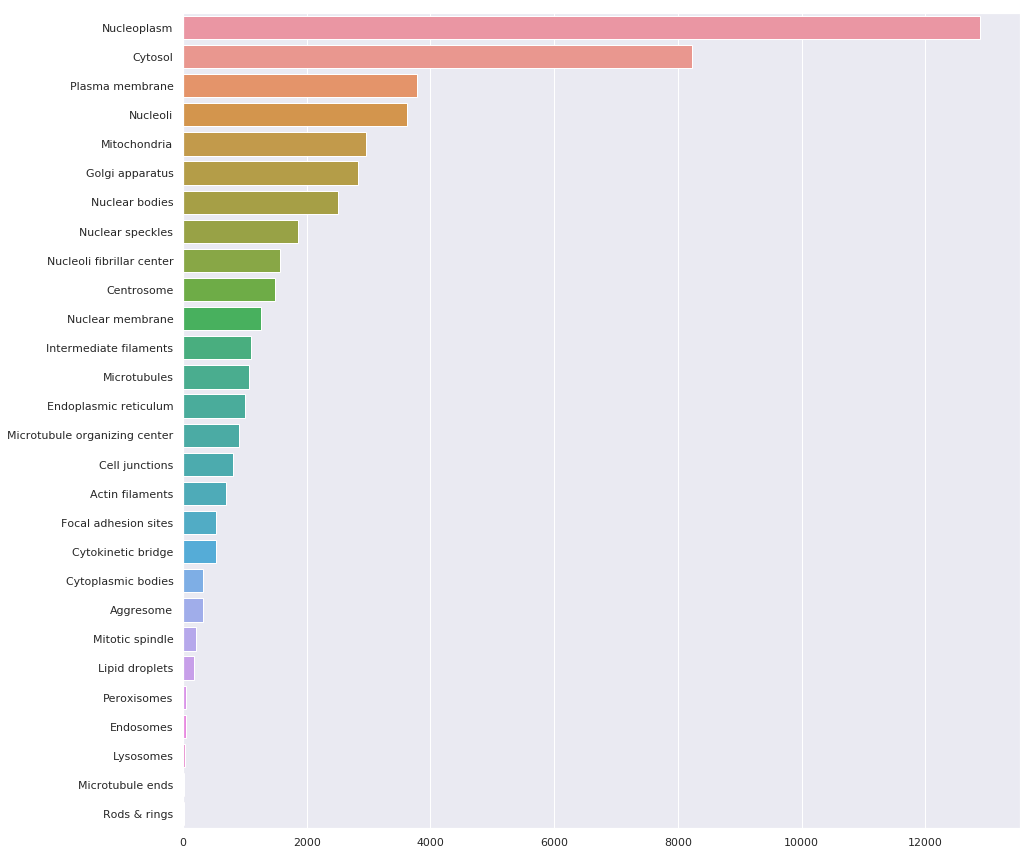

In [20]:
#generates a bar plot for the frequency of targets
target_counts = train_labels.drop(["Id", "Target"],axis=1).sum(axis=0).sort_values(ascending=False)
plt.figure(figsize=(15,15))
sns.barplot(y=target_counts.index.values, x=target_counts.values, order=target_counts.index)

### Take-Away

* We can see that most common protein structures belong to coarse grained cellular components like the plasma membrane, the cytosol and the nucleus. 
* In contrast small components like the lipid droplets, peroxisomes, endosomes, lysosomes, microtubule ends, rods and rings are very seldom in our train data. For these classes the prediction will be very difficult as we have only a few examples that may not cover all variabilities and as our model probably will be confused during the learning process by the major classes. Due to this confusion we will make less accurate predictions on the minor classes.
* Consequently accuracy is not the right score here to measure your performance and validation strategy should be very fine. 

## How many targets are most common?

Text(0, 0.5, '% of data')

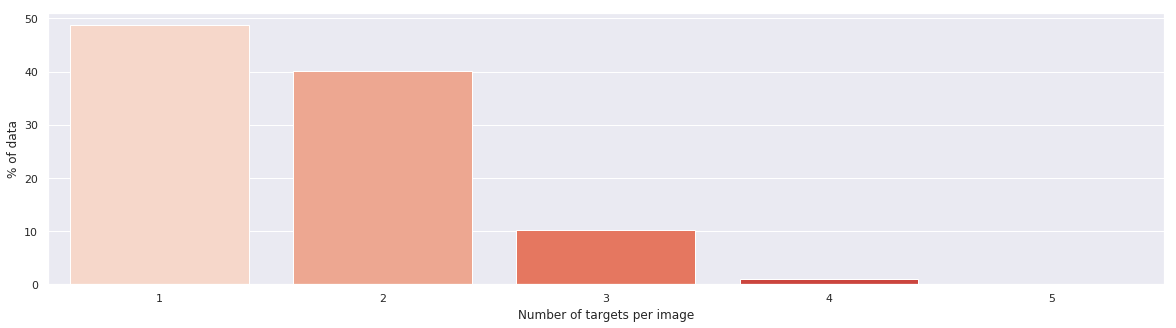

In [21]:
train_labels["number_of_targets"] = train_labels.drop(["Id", "Target"],axis=1).sum(axis=1)
count_perc = np.round(100 * train_labels["number_of_targets"].value_counts() / train_labels.shape[0], 2)
plt.figure(figsize=(20,5))
sns.barplot(x=count_perc.index.values, y=count_perc.values, palette="Reds")
plt.xlabel("Number of targets per image")
plt.ylabel("% of data")

### Take-away

* Most train images only have 1 or two target labels.
* More than 3 targets are very seldom!

## Which targets are correlated?

Let's see if we find some correlations between our targets. This way we may already see that some proteins often come together.

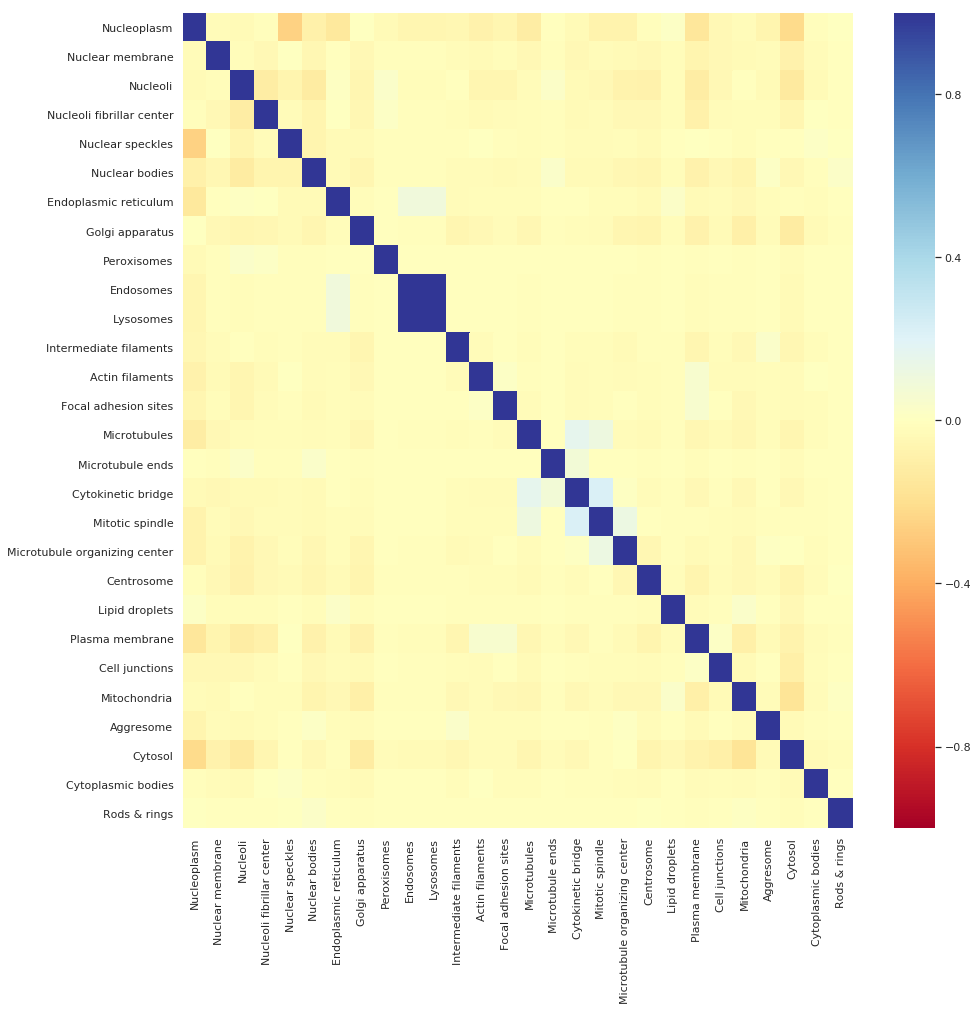

In [22]:
plt.figure(figsize=(15,15))
sns.heatmap(train_labels[train_labels.number_of_targets>1].drop(
    ["Id", "Target", "number_of_targets"],axis=1
).corr(), cmap="RdYlBu", vmin=-1, vmax=1)

### Take-away

* We can see that many targets only have very slight correlations. 
* In contrast, endosomes and lysosomes often occur together and sometimes seem to be located at the endoplasmatic reticulum. 
* In addition we find that the mitotic spindle often comes together with the cytokinetic bridge. This makes sense as both are participants for cellular division. And in this process microtubules and thier ends are active and participate as well. Consequently we find a positive correlation between these targets.

## How are special and seldom targets grouped?

### Lysosomes and endosomes

Let's start with these high correlated features!

In [23]:
def find_counts(special_target, labels):
    counts = labels[labels[special_target] == 1].drop(
        ["Id", "Target", "number_of_targets"],axis=1
    ).sum(axis=0)
    counts = counts[counts > 0]
    counts = counts.sort_values()
    return counts

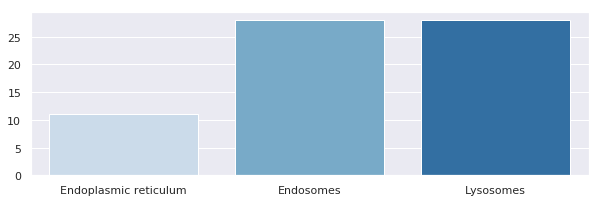

In [24]:
lyso_endo_counts = find_counts("Lysosomes", train_labels)

plt.figure(figsize=(10,3))
sns.barplot(x=lyso_endo_counts.index.values, y=lyso_endo_counts.values, palette="Blues")

### Rods and rings

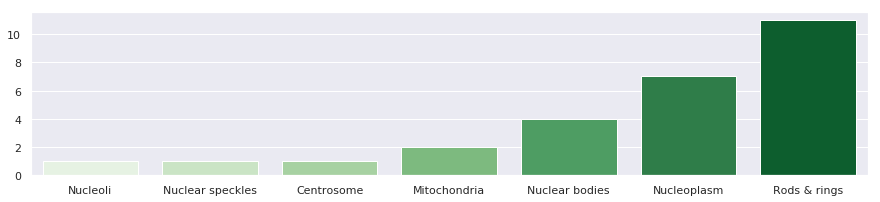

In [25]:
rod_rings_counts = find_counts("Rods & rings", train_labels)
plt.figure(figsize=(15,3))
sns.barplot(x=rod_rings_counts.index.values, y=rod_rings_counts.values, palette="Greens")

### Peroxisomes

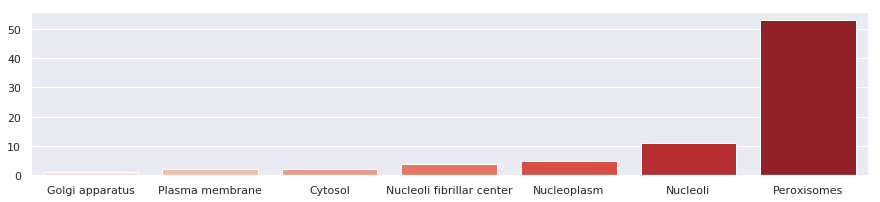

In [26]:
peroxi_counts = find_counts("Peroxisomes", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=peroxi_counts.index.values, y=peroxi_counts.values, palette="Reds")

### Microtubule ends

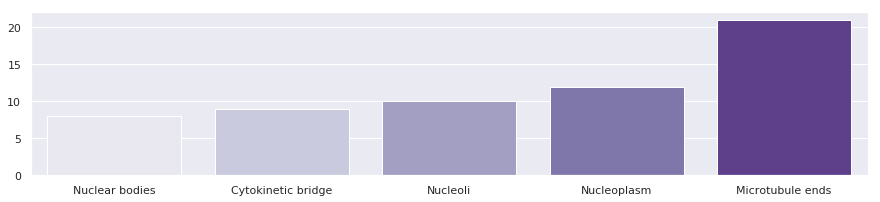

In [27]:
tubeends_counts = find_counts("Microtubule ends", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=tubeends_counts.index.values, y=tubeends_counts.values, palette="Purples")

### Nuclear speckles

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]), <a list of 23 Text xticklabel objects>)

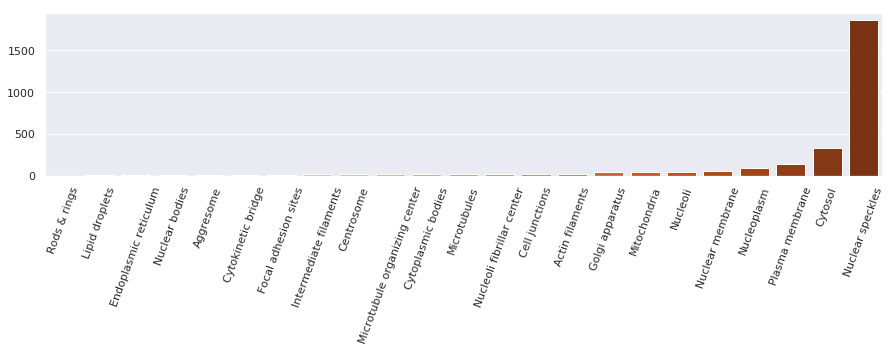

In [28]:
nuclear_speckles_counts = find_counts("Nuclear speckles", train_labels)

plt.figure(figsize=(15,3))
sns.barplot(x=nuclear_speckles_counts.index.values, y=nuclear_speckles_counts.values, palette="Oranges")
plt.xticks(rotation="70")

### Take-away

* We can see that even with very seldom targets we find some kind of grouping with other targets that reveal where the protein structure seems to be located. 
* For example, we can see that rods and rings have something to do with the nucleus whereas peroxisomes may be located in the nucleus as well as in the cytosol.
* Perhaps this patterns might help to build a more robust model!  

## How do the images look like?



### Peek into the directory

Before we start loading images, let's have a look into the train directory to get an impression of what we can find there:

In [29]:
from os import listdir

files = listdir("../input/train")
for n in range(10):
    print(files[n])

a39d2b94-bbae-11e8-b2ba-ac1f6b6435d0_yellow.png
5c4afeae-bbab-11e8-b2ba-ac1f6b6435d0_green.png
a480418c-bbad-11e8-b2ba-ac1f6b6435d0_yellow.png
7e3c58ee-bbad-11e8-b2ba-ac1f6b6435d0_green.png
4ca03104-bba6-11e8-b2ba-ac1f6b6435d0_blue.png
306957fa-bbc8-11e8-b2bc-ac1f6b6435d0_green.png
5b56c138-bbc7-11e8-b2bc-ac1f6b6435d0_yellow.png
45d5f5fe-bbbd-11e8-b2ba-ac1f6b6435d0_yellow.png
e679a030-bbc9-11e8-b2bc-ac1f6b6435d0_red.png
e95822ca-bba8-11e8-b2ba-ac1f6b6435d0_blue.png


Ah, ok, great! It seems that for one image id, there are different color channels present. Looking into the data description of this competition we can find that:

* Each image is actually splitted into 4 different image files. 
* These 4 files correspond to 4 different filter:
    * a **green** filter for the **target protein structure** of interest
    * **blue** landmark filter for the **nucleus**
    * **red** landmark filter for **microtubules**
    * **yellow** landmark filter for the **endoplasmatic reticulum**
* Each image is of size 512 x 512

Let's check if the number of files divided by 4 yields the number of target samples:

In [30]:
len(files) / 4 == train_labels.shape[0]

True

## How do images of specific targets look like?

While looking at examples, we can build an batch loader:

In [31]:
train_path = "../input/train/"

In [32]:
def load_image(basepath, image_id):
    images = np.zeros(shape=(4,512,512))
    images[0,:,:] = imread(basepath + image_id + "_green" + ".png")
    images[1,:,:] = imread(basepath + image_id + "_red" + ".png")
    images[2,:,:] = imread(basepath + image_id + "_blue" + ".png")
    images[3,:,:] = imread(basepath + image_id + "_yellow" + ".png")
    return images

def make_image_row(image, subax, title):
    subax[0].imshow(image[0], cmap="Greens")
    subax[1].imshow(image[1], cmap="Reds")
    subax[1].set_title("stained microtubules")
    subax[2].imshow(image[2], cmap="Blues")
    subax[2].set_title("stained nucleus")
    subax[3].imshow(image[3], cmap="Oranges")
    subax[3].set_title("stained endoplasmatic reticulum")
    subax[0].set_title(title)
    return subax

def make_title(file_id):
    file_targets = train_labels.loc[train_labels.Id==file_id, "Target"].values[0]
    title = " - "
    for n in file_targets:
        title += label_names[n] + " - "
    return title

In [33]:
class TargetGroupIterator:
    
    def __init__(self, target_names, batch_size, basepath):
        self.target_names = target_names
        self.target_list = [reverse_train_labels[key] for key in target_names]
        self.batch_shape = (batch_size, 4, 512, 512)
        self.basepath = basepath
    
    def find_matching_data_entries(self):
        train_labels["check_col"] = train_labels.Target.apply(
            lambda l: self.check_subset(l)
        )
        self.images_identifier = train_labels[train_labels.check_col==1].Id.values
        train_labels.drop("check_col", axis=1, inplace=True)
    
    def check_subset(self, targets):
        return np.where(set(targets).issubset(set(self.target_list)), 1, 0)
    
    def get_loader(self):
        filenames = []
        idx = 0
        images = np.zeros(self.batch_shape)
        for image_id in self.images_identifier:
            images[idx,:,:,:] = load_image(self.basepath, image_id)
            filenames.append(image_id)
            idx += 1
            if idx == self.batch_shape[0]:
                yield filenames, images
                filenames = []
                images = np.zeros(self.batch_shape)
                idx = 0
        if idx > 0:
            yield filenames, images
            

Let's try to visualize specific target groups. **In this example we will see images that contain the protein structures lysosomes or endosomes**. Set target values of your choice and the target group iterator will collect all images that are subset of your choice:

In [34]:
your_choice = ["Lysosomes", "Endosomes"]
your_batch_size = 3

In [35]:
imageloader = TargetGroupIterator(your_choice, your_batch_size, train_path)
imageloader.find_matching_data_entries()
iterator = imageloader.get_loader()

To keep the kernel dense, the target group iterator has a batch size which stands for the number of examples you like to look at once. In this example you can see a maximum amount of 3 images at one iteration.  **To observe the next 3 examples of your target group, just run the cell below again.** This way you can run the cell until you have seen all images of your group without polluting the kernel:

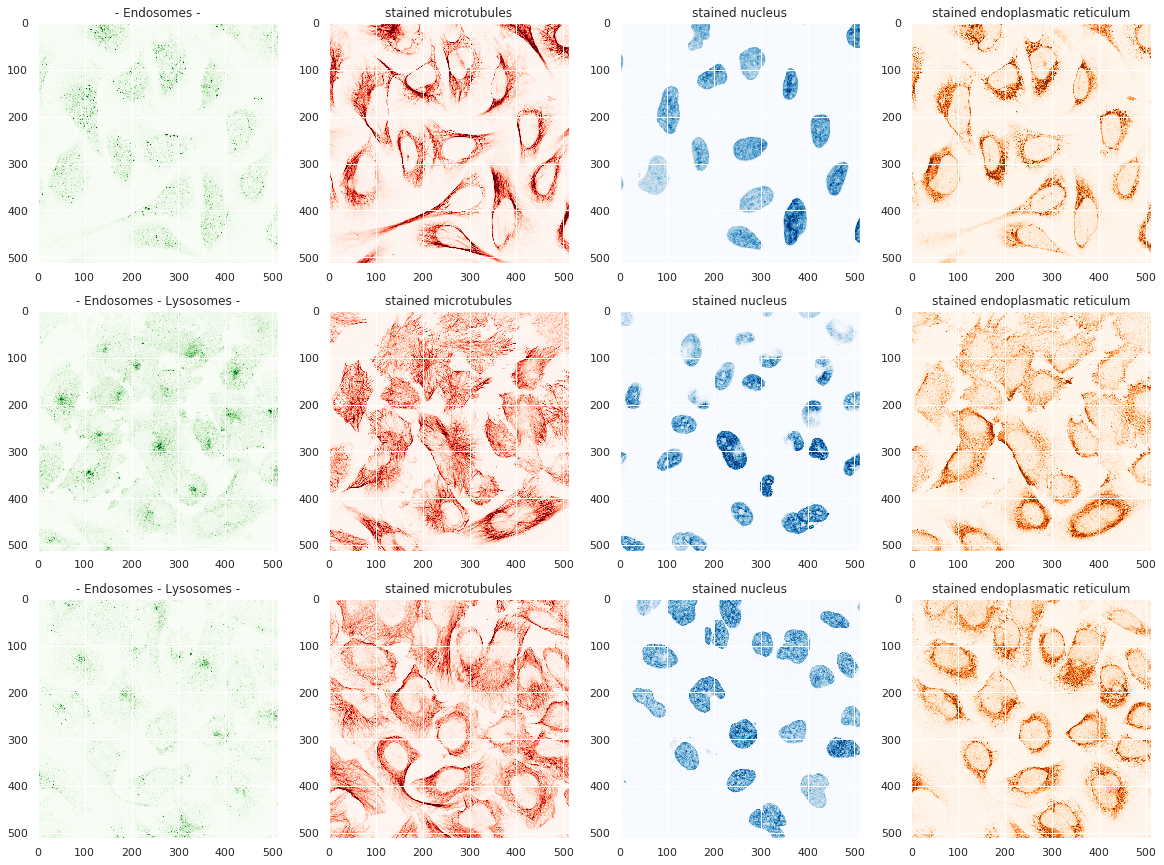

In [36]:
file_ids, images = next(iterator)

fig, ax = plt.subplots(len(file_ids),4,figsize=(20,5*len(file_ids)))
if ax.shape == (4,):
    ax = ax.reshape(1,-1)
for n in range(len(file_ids)):
    make_image_row(images[n], ax[n], make_title(file_ids[n]))

### Take-Away

* Looking at this few examples we can already obtain some insights:
    * The staining of target proteins in the green channel was not equally successful. The **images differ in their intensities and the target proteins are not always located the same way**. The first image you can get by the loader shows endosomes that are spread all over the cells and in the second and third you can find endosomes and lysosomes more concetrated around the nucleus. 
    * Especially **in the red channel we can see morphological differences**. It looks like if the cells are of different types. This is just an assumption but perhaps one could use the red channel information to reveal cell types. 

## Building a baseline model

### K-Fold Cross-Validation

Let's see how many test and train samples we have in this competition:

In [37]:
train_files = listdir("../input/train")
test_files = listdir("../input/test")
percentage = np.round(len(test_files) / len(train_files) * 100)

print("The test set size turns out to be {} % compared to the train set.".format(percentage))

The test set size turns out to be 38.0 % compared to the train set.


To understand the performance of our model we will use **k-fold cross validation**. The train data is splitted into k chunks and each chunk is used once for testing the prediction performance whereas the others are used for training. As our targets show relationships seemed to be grouped somehow the performance per test chunk probably highly depends on the target distribution per test chunk. For example there could be chunks with very seldom targets that may obtain a bad score and some chunks with very common targets and a very good score. To reduce this effect, we will **repeat the K-Fold several times** and look at scoing distributions in the end.

As our test data is 38 % of size compared to the train set it makes sense to use 3-Fold cross validation where the test set is 33 % of size compared to the train set. As we are working with neural networks that can be demanding in computational resources, let's only use 2 repetitions. 

In [38]:
from sklearn.model_selection import RepeatedKFold

splitter = RepeatedKFold(n_splits=3, n_repeats=1, random_state=0)

This splitter is now a generator. Hence if you call splitters split method it will yield one Fold of the repeated K-Folds. Consequently if we choose n_repeats=2 we will end up with 6 Folds in total: 3 Folds for the first cross validation and again 3 Folds for the repeated cross validation. We will perform the splitting on the image ids. This way we can easily load images and targets given the chunk ids. **Due to performance reasons I will only use one cv-fold to explore results and one repeat!**

In [39]:
partitions = []

for train_idx, test_idx in splitter.split(train_labels.index.values):
    partition = {}
    partition["train"] = train_labels.Id.values[train_idx]
    partition["validation"] = train_labels.Id.values[test_idx]
    partitions.append(partition)
    print("TRAIN:", train_idx, "TEST:", test_idx)
    print("TRAIN:", len(train_idx), "TEST:", len(test_idx))

TRAIN: [    1     2     3 ... 31063 31064 31065] TEST: [    0     4     6 ... 31069 31070 31071]
TRAIN: 20714 TEST: 10358
TRAIN: [    0     4     6 ... 31069 31070 31071] TEST: [    1     2     3 ... 31060 31061 31065]
TRAIN: 20715 TEST: 10357
TRAIN: [    0     1     2 ... 31069 31070 31071] TEST: [   10    11    13 ... 31062 31063 31064]
TRAIN: 20715 TEST: 10357


In [40]:
partitions[0]["train"][0:5]

array(['000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0',
       '000a9596-bbc4-11e8-b2bc-ac1f6b6435d0',
       '000c99ba-bba4-11e8-b2b9-ac1f6b6435d0',
       '001bcdd2-bbb2-11e8-b2ba-ac1f6b6435d0',
       '002daad6-bbc9-11e8-b2bc-ac1f6b6435d0'], dtype=object)

### Collecting ideas

Next we need to setup a simple baseline model. This need not be very complex or very good. Its our first attempt to play with and to figure out how to improve. For this purpose let's use the deep learning library [keras](https://keras.io/). This tools makes it easy for us to build and train neural networks. First of all, we should collect some ideas:

* To **stay simple let's use only the green channel image of our images per id**. The competition says that it shows the stained target proteins and consequently it's hopefully the most informative one. The other images are like references showing microtubules, nucleus and endoplasmatic reticulum. We don't acutally now how informative they are and in our current state they would blow up our neural network with a huge amount of network weigths that we might not need.
* Let's use **generators to only load data images of our batch and not all in once**. Using keras fit_generator, evaluate_generator and predict_generator we can directly connect them to keras without worrying much about how keras does its job. For this purpose I highly follow a descprition of a post in the www for which you will find the link below.
* It could be advantegous to write a **small class that does simple preprocessing per image.** This way we can easily change something of this phase without producing chaos in the model itself or during data loading.   
* I'm going to use a **small class that hold parameters that are used or shared between the data loader, the image preprocessor and the baseline model**. Passing an instance of this class to them reduced the risk of setting different parameters and obtaining mismatch errors for example during build & compile of the network layers. 


### Shared Parameter class

In [84]:
class ModelParameter:
    
    def __init__(self, basepath,
                 num_classes=28,
                 image_rows=512,
                 image_cols=512,
                 batch_size=32,
                 n_channels=1,
                 row_scale_factor=4,
                 col_scale_factor=4,
                 shuffle=False,
                 n_epochs=1):
        self.basepath = basepath
        self.num_classes = num_classes
        self.image_rows = image_rows
        self.image_cols = image_cols
        self.batch_size = batch_size
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.row_scale_factor = row_scale_factor
        self.col_scale_factor = col_scale_factor
        self.scaled_row_dim = np.int(self.image_rows / self.row_scale_factor)
        self.scaled_col_dim = np.int(self.image_cols / self.col_scale_factor)
        self.n_epochs = n_epochs

Ok, now we will create an instance of this class and pass it to the DataGenerator, the BaseLineModel and the ImagePreprocessor.

In [85]:
parameter = ModelParameter(train_path)

### Image Preprocessor

Let's write a simple image preprocessor that handles for example the rescaling of the images. Perhaps we can expand its functionality during improvement of the baseline model. 

In [86]:
from skimage.transform import resize

class ImagePreprocessor:
    
    def __init__(self, modelparameter):
        self.parameter = modelparameter
        self.basepath = self.parameter.basepath
        self.scaled_row_dim = self.parameter.scaled_row_dim
        self.scaled_col_dim = self.parameter.scaled_col_dim
        self.n_channels = self.parameter.n_channels
    
    def preprocess(self, image):
        image = self.resize(image)
        image = self.reshape(image)
        image = self.normalize(image)
        return image
    
    def resize(self, image):
        image = resize(image, (self.scaled_row_dim, self.scaled_col_dim))
        return image
    
    def reshape(self, image):
        image = np.reshape(image, (image.shape[0], image.shape[1], self.n_channels))
        return image
    
    def normalize(self, image):
        image /= 255 
        return image
    
    def load_image(self, image_id):
        image = np.zeros(shape=(512,512,4))
        image[:,:,0] = imread(self.basepath + image_id + "_green" + ".png")
        image[:,:,1] = imread(self.basepath + image_id + "_blue" + ".png")
        image[:,:,2] = imread(self.basepath + image_id + "_red" + ".png")
        image[:,:,3] = imread(self.basepath + image_id + "_yellow" + ".png")
        return image[:,:,0:self.parameter.n_channels]
        

Let's create an instance of this preprocessor and pass it to the data generator.

In [87]:
preprocessor = ImagePreprocessor(parameter)

#### Looking at a preprocessed example image

(512, 512)
(128, 128, 1)


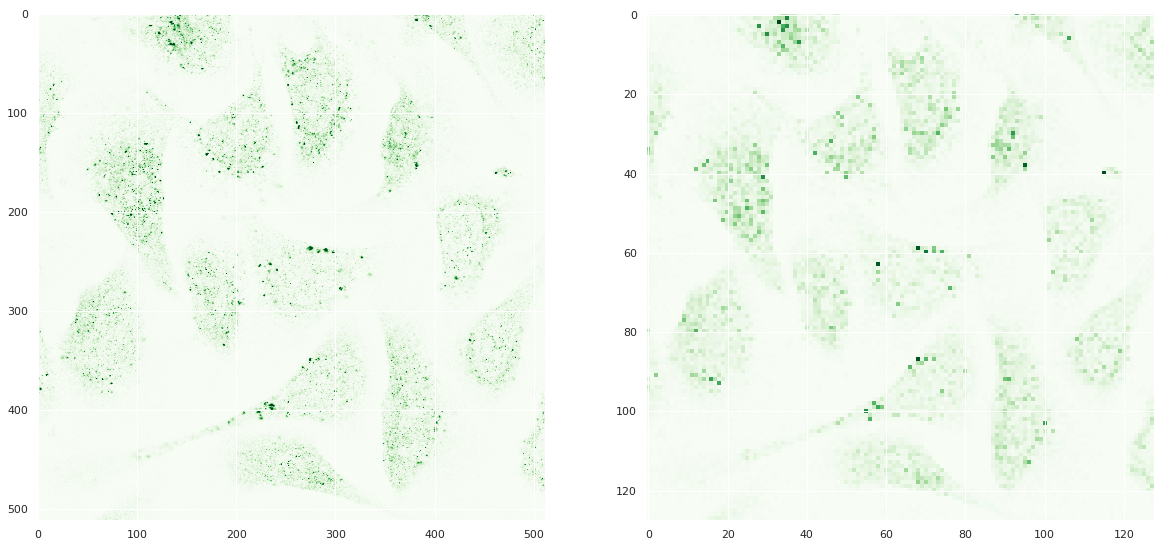

In [88]:
example = images[0,0]
preprocessed = preprocessor.preprocess(example)
print(example.shape)
print(preprocessed.shape)

fig, ax = plt.subplots(1,2,figsize=(20,10))
ax[0].imshow(example, cmap="Greens")
ax[1].imshow(preprocessed.reshape(parameter.scaled_row_dim,parameter.scaled_col_dim), cmap="Greens")

You can see that we have lost a lot of information by downscaling the image!

### Data Generator

I highly build upon the [nice data generator presented by Shervine Amidi.](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly) Thank you! :-) 


In [89]:
import keras

class DataGenerator(keras.utils.Sequence):
    
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor):
        self.params = modelparameter
        self.labels = labels
        self.list_IDs = list_IDs
        self.dim = (self.params.scaled_row_dim, self.params.scaled_col_dim)
        self.batch_size = self.params.batch_size
        self.n_channels = self.params.n_channels
        self.num_classes = self.params.num_classes
        self.shuffle = self.params.shuffle
        self.preprocessor = imagepreprocessor
        self.on_epoch_end()
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                ["Id", "Target", "number_of_targets"], axis=1).values
            
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size, self.num_classes), dtype=int)
        # Generate data
        for i, identifier in enumerate(list_IDs_temp):
            # Store sample
            image = self.preprocessor.load_image(identifier)
            image = self.preprocessor.preprocess(image)
            X[i] = image
            # Store class
            y[i] = self.get_targets_per_image(identifier)
        return X, y
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))
    
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        # Generate data
        X, y = self.__data_generation(list_IDs_temp)
        return X, y

In [90]:
class PredictGenerator:
    
    def __init__(self, predict_Ids, imagepreprocessor, predict_path):
        self.preprocessor = imagepreprocessor
        self.preprocessor.basepath = predict_path
        self.identifiers = predict_Ids
    
    def predict(self, model):
        y = np.empty(shape=(len(self.identifiers), self.preprocessor.parameter.num_classes))
        for n in range(len(self.identifiers)):
            image = self.preprocessor.load_image(self.identifiers[n])
            image = self.preprocessor.preprocess(image)
            image = image.reshape((1, *image.shape))
            y[n] = model.predict(image)
        return y

### CNN Baseline model using keras

In [91]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, BatchNormalization, regularizers
from keras.layers import Conv2D, MaxPooling2D
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, Adam
from keras.models import load_model

In [92]:
class BaseLineModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

VGG 16 model

In [93]:
class VGGModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
        self.chanDim = -1
    
    def build_model(self):
        self.model = Sequential()
        # CONV => RELU => POOL
        self.model.add(Conv2D(32, (3, 3), padding="same", input_shape=self.input_shape,activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(MaxPooling2D(pool_size=(3, 3)))
        self.model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        self.model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(Conv2D(64, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))
        # (CONV => RELU) * 2 => POOL
        self.model.add(Conv2D(128, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(Conv2D(128, (3, 3), padding="same",activation='relu'))
        self.model.add(BatchNormalization(axis=self.chanDim))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Dropout(0.25))

        # first (and only) set of FC => RELU layers
        self.model.add(Flatten())
        self.model.add(Dense(1024,activation='relu'))
        self.model.add(BatchNormalization())
        self.model.add(Dropout(0.5))
        
        # use a *softmax* activation for single-label classification
        # and *sigmoid* activation for multi-label classification
        self.model.add(Dense(self.num_classes, activation='sigmoid'))

    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8,verbose=1)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

### Training the baseline on the first cv-fold

In [94]:
# Datasets
partition = partitions[0]
labels = train_labels

print("Number of samples in train: {}".format(len(partition["train"])))
print("Number of samples in validation: {}".format(len(partition["validation"])))

Number of samples in train: 20714
Number of samples in validation: 10358


In [95]:
training_generator = DataGenerator(partition['train'], labels, parameter, preprocessor)
validation_generator = DataGenerator(partition['validation'], labels, parameter, preprocessor)
predict_generator = PredictGenerator(partition['validation'], preprocessor, train_path)

In [96]:
# # Run computation and store results as csv
# #if kernelsettings.fit_baseline == True:
# model = BaseLineModel(parameter)
# model.build_model()
# model.compile_model()
# model.set_generators(training_generator, validation_generator)
# history = model.learn()
# model.save("baseline_model.h5")
# proba_predictions = model.predict(predict_generator)
# baseline_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
#         ["Target", "number_of_targets", "Id"], axis=1).columns)
# baseline_proba_predictions.to_csv("baseline_predictions.csv")


# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
#else:
baseline_proba_predictions = pd.read_csv("baseline_predictions.csv", index_col=0)

Even though this accuracy looks nice it's an illusion! We are far away from a good model. Let's try to understand why...

## Train VGG Model

In [ ]:
# Run computation and store results as csv
#if kernelsettings.fit_baseline == True:
parameter_vgg = ModelParameter(train_path,n_epochs=5)
model = VGGModel(parameter_vgg)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("vgg16_model.h5")
proba_predictions = model.predict(predict_generator)
vgg_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
vgg_proba_predictions.to_csv("vgg16_predictions.csv")


# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
#else:
#baseline_proba_predictions = pd.read_csv("baseline_predictions.csv", index_col=0)

Epoch 1/5
646/647 [============================>.] - ETA: 3s - loss: 0.2608 - acc: 0.9069

## ResNet Model

In [ ]:
from keras.applications.resnet50 import ResNet50

In [ ]:
model = ResNet50(weights="imagenet")

In [ ]:
class ResNetModel:
    
    def __init__(self, modelparameter):
        self.params = modelparameter
        self.num_classes = self.params.num_classes
        self.img_rows = self.params.scaled_row_dim
        self.img_cols = self.params.scaled_col_dim
        self.n_channels = self.params.n_channels
        self.input_shape = (self.img_rows, self.img_cols, self.n_channels)
        self.my_metrics = ['accuracy']
        self.chanDim = -1
    
    def build_model(self):
        
        
        
    
    def compile_model(self):
        self.model.compile(loss=keras.losses.binary_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=self.my_metrics)
    
    def set_generators(self, train_generator, validation_generator):
        self.training_generator = train_generator
        self.validation_generator = validation_generator
    
    def learn(self):
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8,verbose=1)
    
    def score(self):
        return self.model.evaluate_generator(generator=self.validation_generator,
                                      use_multiprocessing=True, 
                                      workers=8)
    
    def predict(self, predict_generator):
        y = predict_generator.predict(self.model)
        return y
    
    def save(self, modeloutputpath):
        self.model.save(modeloutputpath)
    
    def load(self, modelinputpath):
        self.model = load_model(modelinputpath)

In [ ]:
# Run computation and store results as csv
#if kernelsettings.fit_baseline == True:
parameter_resnet = ModelParameter(train_path,n_epochs=5)
model = ResNetModel(parameter_resnet)
model.build_model()
model.compile_model()
model.set_generators(training_generator, validation_generator)
history = model.learn()
model.save("resnet_model.h5")
proba_predictions = model.predict(predict_generator)
vgg_proba_predictions = pd.DataFrame(proba_predictions, columns=train_labels.drop(
        ["Target", "number_of_targets", "Id"], axis=1).columns)
vgg_proba_predictions.to_csv("resnet_predictions.csv")


## Experiment: Add regularization

## What do the results tell us?

Let's have a look at predicted probabilites per target class:

In [42]:
validation_labels = train_labels.loc[train_labels.Id.isin(partition["validation"])]

With our new strategy to perform predictions we should obtain the same shape[0] of the true targets and the predicted ones:

In [43]:
print(validation_labels.shape)
print(baseline_proba_predictions.shape)

(10358, 31)
(10358, 28)


Hmmmm this still looks not good :-( Have to search even further. 

In [44]:
baseline_proba_predictions.tail()

,Nucleoplasm,Nuclear membrane,Nucleoli,Nucleoli fibrillar center,Nuclear speckles,Nuclear bodies,Endoplasmic reticulum,Golgi apparatus,Peroxisomes,Endosomes,...,Microtubule organizing center,Centrosome,Lipid droplets,Plasma membrane,Cell junctions,Mitochondria,Aggresome,Cytosol,Cytoplasmic bodies,Rods & rings
10353,0.405442,0.019475,0.096490,0.040893,0.051506,0.080357,0.026848,0.101955,0.016413,0.007232,...,0.011176,0.044507,0.009478,0.061817,0.016543,0.093321,0.022078,0.182599,0.014503,0.006611
10354,0.391198,0.018363,0.098836,0.045386,0.051529,0.082826,0.025817,0.103776,0.016171,0.007529,...,0.009710,0.043578,0.009023,0.052368,0.016416,0.097127,0.022203,0.160257,0.016091,0.006242
10355,0.410812,0.020428,0.098244,0.039863,0.051948,0.078806,0.027718,0.101767,0.016680,0.007337,...,0.011656,0.045337,0.009906,0.065310,0.016901,0.093401,0.022121,0.191832,0.014297,0.006886
10356,0.499616,0.032202,0.087654,0.008287,0.033825,0.033290,0.042252,0.065632,0.020358,0.003218,...,0.031055,0.048695,0.010913,0.252322,0.014540,0.044719,0.019315,0.509550,0.004295,0.008241
10357,0.428234,0.023606,0.099626,0.040282,0.057131,0.083005,0.031554,0.107602,0.018144,0.008103,...,0.014800,0.051060,0.011655,0.080586,0.019183,0.095330,0.024362,0.217976,0.014662,0.008476


In [45]:
proba_predictions = baseline_proba_predictions.values

/home/xrq980914/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Percentage')

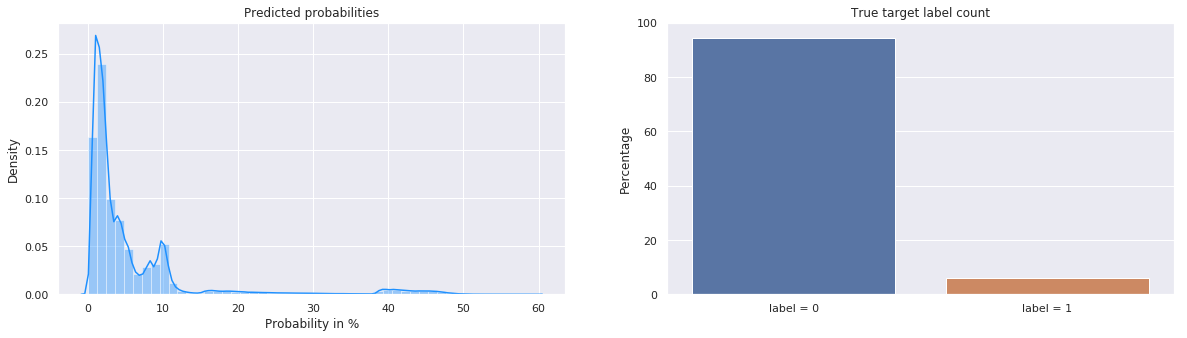

In [46]:
hot_values = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).values.flatten()
one_hot = (hot_values.sum()) / hot_values.shape[0] * 100
zero_hot = (hot_values.shape[0] - hot_values.sum()) / hot_values.shape[0] * 100

fig, ax = plt.subplots(1,2, figsize=(20,5))
sns.distplot(proba_predictions.flatten() * 100, color="DodgerBlue", ax=ax[0])
ax[0].set_xlabel("Probability in %")
ax[0].set_ylabel("Density")
ax[0].set_title("Predicted probabilities")
sns.barplot(x=["label = 0", "label = 1"], y=[zero_hot, one_hot], ax=ax[1])
ax[1].set_ylim([0,100])
ax[1].set_title("True target label count")
ax[1].set_ylabel("Percentage")

### Take-Away

* We can see that our model was always very uncertain to predict the presence of a target protein. All probabilities are close to zero and there are only a few with targets where our model predicted a protein structure with higher than 10 %.
* If we take a look at the true target label count we can see that most of our targets are filled with zero. This corresponds to an absence of corresponding target proteins. This makes sense: For each image we have a high probability to contain either 1 or 2 target protein structures. Their label values are one whereas all others are zero. 
* Consequently our high accuracy belongs to the high correct prediction of the absence of target proteins. In contrast we weren't able to predict the presence of a target protein which is the most relevant part! 
* Now a bell should ring :-) Have you ever heard about imbalanced classes and model confusion? 

### To which targets do the high and small predicted probabilities belong to?

Text(0.5, 1.0, 'Standard deviation of predicted probability per class over all samples')

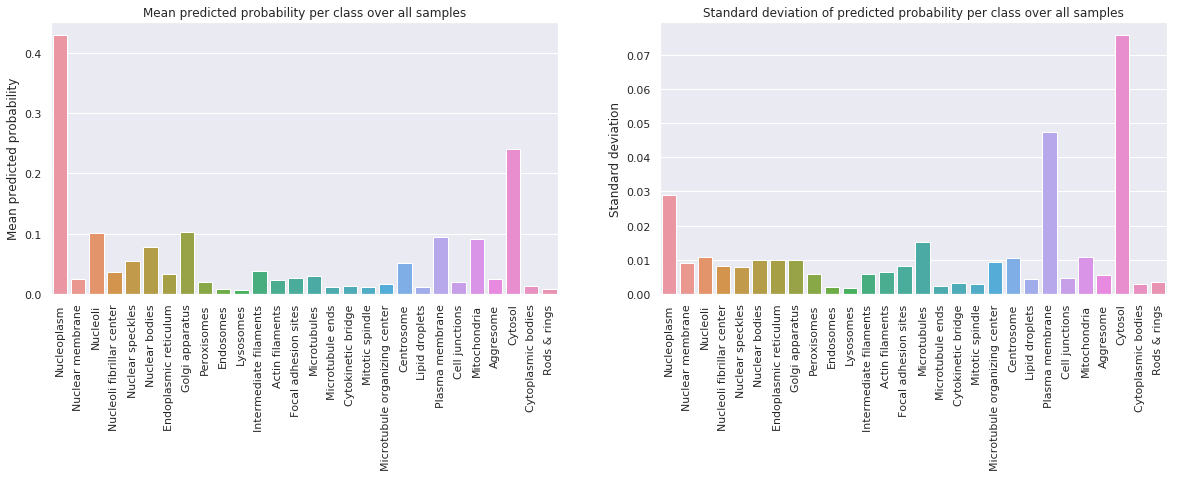

In [47]:
mean_predictions = np.mean(proba_predictions, axis=0)
std_predictions = np.std(proba_predictions, axis=0)
mean_targets = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).mean()

labels = validation_labels.drop(["Id", "Target", "number_of_targets"], axis=1).columns.values

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x=labels,
            y=mean_predictions,
            ax=ax[0])
ax[0].set_xticklabels(labels=labels,
                      rotation=90)
ax[0].set_ylabel("Mean predicted probability")
ax[0].set_title("Mean predicted probability per class over all samples")
sns.barplot(x=labels,
           y=std_predictions,
           ax=ax[1])
ax[1].set_xticklabels(labels=labels,
                      rotation=90)
ax[1].set_ylabel("Standard deviation")
ax[1].set_title("Standard deviation of predicted probability per class over all samples")

Text(0.5, 1.0, 'Percentage of hot counts (ones) per target class')

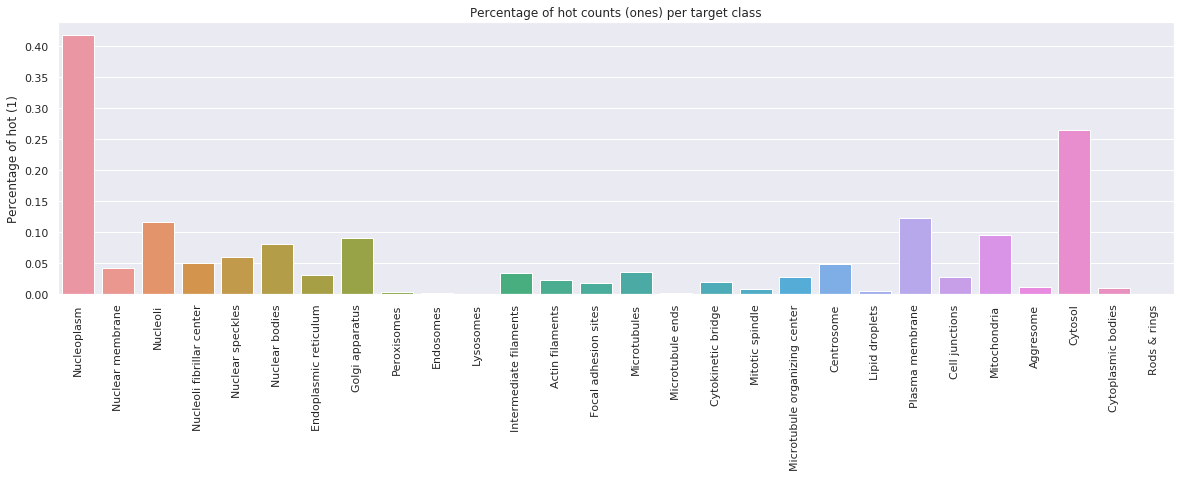

In [48]:
fig, ax = plt.subplots(1,1,figsize=(20,5))
sns.barplot(x=labels, y=mean_targets.values, ax=ax)
ax.set_xticklabels(labels=labels,
                      rotation=90)
ax.set_ylabel("Percentage of hot (1)")
ax.set_title("Percentage of hot counts (ones) per target class")

### Take-Away

* Our baseline model seemed to learn something even if this something does not look very nice. 
* Taking a look at the standard deviation we can see that all samples have nearly the same predicted values. There is no deviation, no difference between them. This is of course very bad! :-(

Let's go one step deeper and take a look at the Cytosol (choose another feature if you like ;-)). Here we can see a higher standard deviation than for all other samples and perhaps its corresponding distribution starts to diverge, trying to get bimodal. This would be great at it indicates that the model starts solving the problem of binary classification for this target:

In [49]:
feature = "Cytosol"

(0, 1)

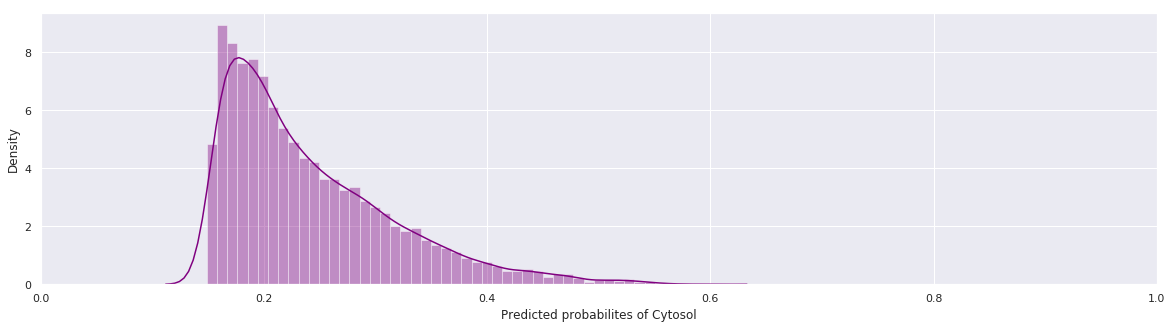

In [50]:
plt.figure(figsize=(20,5))
sns.distplot(baseline_proba_predictions[feature].values[0:-10], color="Purple")
plt.xlabel("Predicted probabilites of {}".format(feature))
plt.ylabel("Density")
plt.xlim([0,1])

No, it does not seem that our model starts to separate well. The mode is close to the fraction of one-hot-counts over all samples. At least the flat tail gives hope that learning could be in progress.  But even though our next goal should be to find out what to tune in such a way that our model really starts learning! 

## One-Step-Improvement


Ok, again let's go one step back and choose the most common target proteins that are present in our data: nucleoplasm, cytosol and plasma membrane. If we are not able to predict them we can go home and stay in bed ;-) .

In [ ]:
wishlist = ["Nucleoplasm", "Cytosol", "Plasma membrane"]

### The target wish list

To introduce a target wishlist that we can change whenever we want we need to improve the data generator. For this purpose we're going to extend the class we have already written. Taking a closer look at the base generator you can see that there is just one line code in def data_generation(self, list_IDs_temp) we have to change, namely the part with y[i] = ... inside the for loop over temp list ids (image identifiers of the batch). To make things easier, I added a small method to the DataGenerator we already had:

```
def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier].drop(
                ["Id", "Target", "number_of_targets"], axis=1).values
```

This method just avoids the direct pass to y[i], the targets per image in a batch. Now, we can overwrite this method in our ImprovedDataGenerator without loosing functionality:

In [ ]:
class ImprovedDataGenerator(DataGenerator):
    
    # in contrast to the base DataGenerator we add a target wishlist to init
    def __init__(self, list_IDs, labels, modelparameter, imagepreprocessor, target_wishlist):
        super().__init__(list_IDs, labels, modelparameter, imagepreprocessor)
        self.target_wishlist = target_wishlist
    
    def get_targets_per_image(self, identifier):
        return self.labels.loc[self.labels.Id==identifier][self.target_wishlist].values

### Plug and Play

:-) 

This part makes fun! Actually I don't know if our model learns something meaningful. But we can try to find out by improving our model adding **new features** and playing with **different parameter settings**. The latter I like to do in a **plug-and-play style**: Setting the flag *improve=True* adds a change to our model whereas *improve=False* uses the old concept we already used in the baseline. 



### Add scoring metrics

We have already seen that the accuracy score is an illusion and does not help to figure out how good our predictions are. Let's take a closer look to the competition scoring and alternatives:

* **F1 macro score**: Check out this [nice implementation of Guglielmo Camporese](https://www.kaggle.com/guglielmocamporese/macro-f1-score-keras). Thank you very much! We can easily add it to our model.
* But even with that score we should be careful! We have 28 different classes that are **very different in their frequency of being present**.  In addition we have to deal with **highly imbalanced classes per single target**. Even for the most common target nucleoplasm there are only 40 % of samples that show it and 60 % not. This imbalance becomes even more dramatic for seldom targets like rods and rings. We should **attach more importance to true positives**. 
* Well, there is **one problem with the competition score** that we can use to measure the performance of our model: **The f1 mean**. The mean is not robust towards outliers and consequently not very informative to understand the distribution of f1 scores for each target class. Perhaps we will make nice predictions for Cytosol but bad ones for Nucleoplasmn... who knows? Consequently it could be nice to introduce some further statistical quantities like **min** as well as **max** and the **standard deviation** . This way we can see the worst and gain some insights how the scores are spread over the classes. 

In [ ]:
import keras.backend as K

def base_f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return f1

def f1_min(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.min(f1)

def f1_max(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.max(f1)

def f1_mean(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.mean(f1)

def f1_std(y_true, y_pred):
    f1 = base_f1(y_true, y_pred)
    return K.std(f1)

### Track losses and scores

Ok, after adding the metrics we like to observe we should try to obtain more insights into the learning process of our model. One question on my mind draws circles: **What happened to the loss after each batch during one epoch?** Does it converge? Has our model started to learn or does nothing happen? Currently we obtain a history after calling fit_generator, but this history only contains the loss of train and validation data after one epoch. It does not contain losses that are obtained after computing each batch. But wait a minute... **How does our model update gradients? After each batch? After one epoch?** 

If we take a look at simple feedforward networks that are close related to CNNs add gradient descent, we can see that learning means to compute the derivatives of the loss with respect to the weights over all samples:

$$ w_{i,j}^{new} = w_{i,j}^{old} - \eta \cdot \partial_{w_{i,j}} E$$

With a set of independent observation samples, we can obtain the gradients this way:

$$ \partial_{w_{i,j}} E = \sum_{n=1}^{N} \partial_{w_{i,j}} E_{n}$$


We are computing the change of the loss with respect to a change in the weights for each sample one after another. Consequently in original gradient descent we need to pass the whole dataset once for just one single update step of gradient descent. As our initial weights are not sufficent to solve the classification task we need many such update steps. **But what if the dataset it too large to wait a long time just for one of these steps?**

Perhaps it would be sufficient and already good to use only some $M < N$ of the $N$ samples to compute the gradients $\partial_{w_{i,j}} E$:

$$ \partial_{w_{i,j}} E = \sum_{m=1}^{M} \partial_{w_{i,j}} E_{m} $$

This way **we could use only a batch of samples, compute the gradients and perform the update of weights**. After that we continue by computing the gradients with the next batch. This could be done in sequence of samples or random with replacement. This means that we already start learning without passing the whole dataset. In my case I chose a batch_size of 200. With a total number of samples of around 20000 in my training set this means that I have already done 200 weight updates. **After doing so I have used each sample once and this means the whole dataset was passed through gradient descent**. As far as I know this means, **one epoch**. In addition we can now say that we want to shuffle the samples before doing weight updates after each batch again in the next epoch. This way our model sees a different set, computes some other gradients and hence the loss minimziation could be more robust.   

Improve! :-) We can already see that we might need **more than 1 epoch to learn the pattern in the data**. Computing the gradient with batches is a stochastic process: Depending on the batch samples the gradients may sometimes lead to some good update directions in weight space that points to some minimum of loss.... and sometimes they could lead to the opposite. Well this really depends on the samples within one batch. This becomes more robust with **more samples per batch.** But then we will **need even more epochs** as we make less weight updata aka learning steps! But even if this stochastic gradient descent looks wiggly it has an advantage too: It can escape from local minima of the loss function. That's nice. 

Before we improve the model using more epochs and smaller batches, let's **implement a new feature: a loss callback**. This way we can see if the loss decreases during weight update steps! And we can see if we need more epochs or if the loss has already converged and settled down. 

In [ ]:
class TrackHistory(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [ ]:
class ImprovedModel(BaseLineModel):
    
    def __init__(self, modelparameter,
                 use_dropout,
                 my_metrics=[f1_mean, f1_std, f1_min, f1_max]):
        
        super().__init__(modelparameter)
        self.my_metrics = my_metrics
        self.use_dropout = use_dropout
        
    def learn(self):
        self.history = TrackHistory()
        return self.model.fit_generator(generator=self.training_generator,
                    validation_data=self.validation_generator,
                    epochs=self.params.n_epochs, 
                    use_multiprocessing=True,
                    workers=8,
                    callbacks = [self.history])
    
    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        if self.use_dropout:
            self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        if self.use_dropout:
            self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))

Ok, now let's increase the number of epochs and decrease the batch_size. This way we use more weight update steps and hopefully makes our model learn more than before: 

In [ ]:
parameter = ModelParameter(train_path, num_classes=len(wishlist), n_epochs=5, batch_size=64)
preprocessor = ImagePreprocessor(parameter)
labels = train_labels

In [ ]:
training_generator = ImprovedDataGenerator(partition['train'], labels,
                                           parameter, preprocessor, wishlist)
validation_generator = ImprovedDataGenerator(partition['validation'], labels,
                                             parameter, preprocessor, wishlist)
predict_generator = PredictGenerator(partition['validation'], preprocessor, train_path)

In [ ]:
# Run computation and store results as csv
if kernelsettings.fit_improved_baseline == True:
    model = ImprovedModel(parameter, use_dropout=use_dropout)
    model.build_model()
    model.compile_model()
    model.set_generators(training_generator, validation_generator)
    epoch_history = model.learn()
    proba_predictions = model.predict(predict_generator)
    #model.save("improved_model.h5")
    improved_proba_predictions = pd.DataFrame(proba_predictions, columns=wishlist)
    improved_proba_predictions.to_csv("improved_predictions.csv")
# If you already have done a baseline fit once, 
# you can load predictions as csv and further fitting is not neccessary:
else:
    improved_proba_predictions = pd.read_csv("../input/protein-atlas-eab-predictions/improved_predictions.csv", index_col=0)

In [ ]:
if kernelsettings.fit_improved_baseline == True:
    print(epoch_history.history.keys())
    fig, ax = plt.subplots(2,1,figsize=(20,10))
    ax[0].plot(model.history.losses, color="Red")
    ax[0].set_xlabel("Update step after one batch")
    ax[0].set_ylabel("Train loss")
    ax[0].set_title("Loss evolution batch per batch")
    ax[1].plot(epoch_history.history["val_loss"], color="Green")
    ax[1].plot(epoch_history.history["loss"])
    ax[1].set_title("Loss evolution per epoch")
    ax[1].set_xlabel("Update step after one epoch")
    ax[1].set_ylabel("Loss")
    fig.savefig("losses_improved_model", format="eps")

### What does the loss tell us?
![Losses](https://www.kaggleusercontent.com/kf/7185016/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..3D5GOiotTaFacOc_0ztMkQ.xELnVFi-FwGr8RjlVpZt65KXnyCK5GtztyHgErbUR1iSjxSROPp2jai_q_MHvZMSZ56KGVPQPtCx5j4AegtwsDtZRa8QAT3urcmvDW80qKcuApN7DJWnV7xJxGvfVIInJS_ml5Rma43kvo5NWA3OgXE9qfTJ_zG4C1p95FMUJN8.1bNcwgsup-EREVBNPymfFA/__results___files/__results___118_1.png)

The loss is very noisy! While decreasing the batch size we increased the number of learning steps. Hence our model learns faster. But... with smaller batch size there **are fewer samples to learn from, to compute gradients from**! The gradients we obtain may be very specific to the images and class labels that are covered by the batch of the current learning step. **There was a tradeoff we made**. We gained more learning speed but payed with a reduced gradient quality. Before increasing the batch size again and waiting too long for predictions we might improve by choosing another way:

1. Weight regularization
2. Gradient clipping

These two will be the next improvement steps. Nonetheless, one question remains: Has our model started learning? Can we see a separating force that tries to split zero and one predictions?

### Does our model try to classify?

If this is the case and our model starts learning we should see more bimodal distributions of the predicted probability per target label:

In [ ]:
fig, ax = plt.subplots(3,1,figsize=(25,15))
sns.distplot(improved_proba_predictions.values[:,0], color="Orange", ax=ax[0])
ax[0].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[0]))
ax[0].set_xlim([0,1])
sns.distplot(improved_proba_predictions.values[:,1], color="Purple", ax=ax[1])
ax[1].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[1]))
ax[1].set_xlim([0,1])
sns.distplot(improved_proba_predictions.values[:,2], color="Limegreen", ax=ax[2])
ax[2].set_xlabel("Predicted probabilites of {}".format(improved_proba_predictions.columns.values[2]))
ax[2].set_xlim([0,1])

Jeahy! This looks far better than the distributions we obtained with the baseline model! :-) **Thus increasing epochs while decreasing the batch size helped our model as we made more learning steps.** But... as we have seen by the noise of our losses as well we make large jumps in weight space with each update step. That's not nice! Sometimes these jumps could even lead to exploding losses as well. Then the jump was so big that we escaped from nice regions that lead to a local minimum of loss.

## How can we tackle gradient jiggles?

Let's try to dive deeper into the problem. We compute the gradients with respect to the weights after processing each batch this way:

$$ \partial_{w_{i,j}} E = \sum_{m=1}^{M} \partial_{w_{i,j}} E_{m} $$

Looking at the sum we can see one disadvantage... it's mainly driven by high contributions. **An image in the batch that causes very high positive or negative gradients for the weight $w_{i,j}$ have more impact on the overall gradient than images with low absolute values**. This can be bad especially in the case of outlier images that are not representative to explain the pattern in the data. Consequently our model may try to learn from exotics. In addition we have to be very **careful with small batches as its target distribution might not reflect the overall pattern**. Imagine we would try to distinguish dogs from cats. With a batch size of 10 we are likely to fill up these places with imbalanced targets. For example it could be occupied with cats only. This would yield gradients that try to improve the detection of cats thereby changing the weights we might need to identify dogs. Hence beside image outliers the target distribution itself influences the learning as well. This can cause jiggles as well. One step we try to improve nucleoplasmn and the next perhaps cytosol but with a downgrade of the nucleoplasmn predictions and the next steps it could be the other way round. 

How to solve this jiggle-wiggle problem?

Well, first of all we might choose a higher batch_size again :-) Decreasing the batch size we made a tradeoff: We increased the learning speed but increased the risk of low quality gradients. Hence before playing with further strategies, we should make a step backwards again. With a batch_size of 128 and number of epochs 10, we obtain these losses:

### Dropout Layer

I often read that dropout helps to avoid overfitting but for me it seems that there is one more useful advantage: Imagine the cat-problem above - Given a batch full of cats we only compute gradients for making the predictions of cats better. And this can be done to the detriment of the dogs as both classes share weights. Hence changing the weights with batches of imbalanced classes can lead to jiggles. 

Now let's consider a dropout-layer: It randomly selects a given percentage of input neurons and drops them during the current training step. Taking a look at [this paper](http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf) (linked at keras documentation) you can see that the forward and backward propagation is done only with this reduced, thinned kind of network. In our case this means that each learning step some weights will be untouched and not used to compute gradients. This is great as this would mean that some weight that could be good for predicting dogs will not change after we process a batch with cats only. ;-)

Consequently if you have a **problem with overfitting** (learning too much out of your training data and loosing generalization performance) **or you have very small, imbalanced batches you should consider dropout** as a strategy. But before turning happy and starting to use dropout frequently, we should think about its downside: Dropping neruons during training and learning with a thinned kind of networks means that **we freeze learning each step a bit**. And the randomness of frosty the dropout snowman can turn to a problem difficult to graps: Which neurons should be dropped, are there some for which dropping is good and some for which it is bad? After which layer in our network does it make sense to use it?Perhaps it would have been better to use some neurons that were dropped a random dropout session during one batch learning step... we don't know. Perhaps we have prevented the success of a learning step given one batch and improved learning given another batch. The information flow through the network is somehow a blackbox for us and this randomness of thinned network learning makes it more difficult to understand what's going on. 

You can see that in my baseline model I'm already using dropout. This choice was somehow arbitrarily as I used an example network that can be found to classify mnist digits as a starting point. Hence let's improve again and **turn dropout to a plug-and-play feature**:

```
class ImprovedModel(BaseLineModel):
    
    def __init__(self, modelparameter,
                 my_metrics=[f1_mean, f1_std, f1_min, f1_max],
                 use_dropout=True):
        
        super().__init__(modelparameter)
        self.my_metrics = my_metrics
        self.use_dropout = use_dropout

    def build_model(self):
        self.model = Sequential()
        self.model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=self.input_shape))
        self.model.add(Conv2D(32, (3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        if self.use_dropout:
            self.model.add(Dropout(0.25))
        self.model.add(Flatten())
        self.model.add(Dense(64, activation='relu'))
        if self.use_dropout:
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.num_classes, activation='sigmoid'))
```

Our last losses were obtained by using dropout with high percentage (25 % and 50 %) of dropped neurons. **What will happen if we do not use our dropout layers?**

![LossWithoutDropout](https://www.kaggleusercontent.com/kf/7212722/eyJhbGciOiJkaXIiLCJlbmMiOiJBMTI4Q0JDLUhTMjU2In0..ZSQ_3svPXTPSUJWGcnFFjQ.IfPN45Kb77RLHEkt96pfewTm-O_B93fu-vw-weY_q8_pXlM8HdkyiFr1bhbJ9BmzzSckS4KvDKa2HNRb4aCJwa9btO4vwA4lUToAsCpRqZeHE5w6u4K1-AG_K6FWdDACoYvy7tP52dJku4zJsEySvTuoUt1qcb4xAsDoIlUMedg.z5L-MIPi65oUJmTJIRqXig/__results___files/__results___120_1.png)

## Where to go next?

* optimization objective alias loss choice
* hyperparameter search